In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from audio_process import *
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import time
from torch.optim.lr_scheduler import OneCycleLR


samplerate = 16000
frame_length_ms = 12
hop_length_samples = 4
# data path
# SRP_audio_path = r'F:\audio\SRP_segmented\Voice'
# SRP_egg_path = r'F:\audio\SRP_segmented\EGG'
# VRP_audio_path = r'F:\audio\10s_segment\VRP_segmented\voice_test'
# VRP_egg_path = r'F:\audio\10s_segment\VRP_segmented\egg_test'
VRP_path = r'F:\audio\test_VRP'


ModuleNotFoundError: No module named 'audio_process'

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. List of all available GPUs:")
    print(torch.cuda.device_count(), "GPUs available")
    for i in range(torch.cuda.device_count()):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("CUDA is not available, using CPU instead.")

import sys
print("Python executable path:", sys.executable)



In [185]:
def load_data(folder_path, samplerate=16000):
    audios = []
    eggs = []
    
    # Walk through the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):
                audio_path = os.path.join(root, file)
                try:
                    # Load file with librosa
                    wave, sr = librosa.load(audio_path, sr=samplerate, mono=False)
                    if wave.shape[0] == 2:  # Ensure it is stereo
                        audio, egg = wave[0], wave[1]
                        audios.append(audio)
                        eggs.append(egg)
                    else:
                        print(f"Skipped {audio_path}: Audio is not stereo.")
                except Exception as e:
                    print(f"Error loading {audio_path}: {str(e)}")

    # Concatenate all collected data into single arrays
    audio_concat = np.concatenate(audios) if audios else np.array([])
    egg_concat = np.concatenate(eggs) if eggs else np.array([])

    return audio_concat, egg_concat

def segment_audio(audio, sr, frame_length_ms=12, hop_length_samples=1):
    frame_length_samples = int(sr * frame_length_ms / 1000)
    # Use stride tricks to avoid explicit Python loops
    shape = (audio.size - frame_length_samples + 1, frame_length_samples)
    strides = (audio.strides[0], audio.strides[0])
    frames = np.lib.stride_tricks.as_strided(audio, shape=shape, strides=strides)[::hop_length_samples]
    return frames

class AudioEGGDataset(Dataset):
    def __init__(self, audio_frames, egg_frames):
        """
        Initializes the dataset with pre-loaded data.
        :param audio_frames: A list or array of preprocessed and segmented audio frames.
        :param egg_frames: A list or array of preprocessed and segmented EGG frames.
        :param transform: Optional transform to be applied on a sample.
        """
        assert len(audio_frames) == len(egg_frames), "Audio and EGG frames must be the same length"
        self.audio_frames = audio_frames
        self.egg_frames = egg_frames

    def __len__(self):
        return len(self.audio_frames)

    def __getitem__(self, idx):
        audio_frame = self.audio_frames[idx]
        egg_frame = self.egg_frames[idx]

        # Convert arrays to PyTorch tensors
        audio_tensor = torch.from_numpy(audio_frame).float().unsqueeze(0)  # Add channel dimension if needed
        egg_tensor = torch.from_numpy(egg_frame).float().unsqueeze(0)      # Add channel dimension if needed

        return audio_tensor, egg_tensor

import torch
from torch import nn

class WaveNet(nn.Module):
    def __init__(self, input_channels, dilation_channels):
        super(WaveNet, self).__init__()
        self.dilation_channels = dilation_channels
        self.receptive_field_size = 1
        self.dilated_convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  # Add batch normalization layers
        self.dropouts = nn.ModuleList()     # Add dropout layers

        dilations = [2**i for i in range(6)]
        self.dilated_convs.append(nn.Conv1d(input_channels, 2 * dilation_channels, kernel_size=3, padding=dilations[0]))
        self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))  # Initialize batch norm for the first conv layer
        self.dropouts.append(nn.Dropout(p=0.1))  # Dropout layer with 10% probability

        for dilation in dilations[1:]:
            padding = dilation * (3 - 1) // 2
            self.dilated_convs.append(nn.Conv1d(dilation_channels, 2 * dilation_channels, kernel_size=3, padding=padding, dilation=dilation))
            self.receptive_field_size += dilation * 2
            self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))
            self.dropouts.append(nn.Dropout(p=0.1))  # Consistent dropout probability across layers

        self.output_conv = nn.Conv1d(dilation_channels, 1, kernel_size=1)

    def forward(self, x):
        for conv, bn, do in zip(self.dilated_convs, self.batch_norms, self.dropouts):
            out = conv(x)
            out = bn(out)  # Apply batch normalization
            # Splitting the output of the convolution into filter and gate parts
            filter, gate = torch.split(out, self.dilation_channels, dim=1)  # Correct dimension for splitting is 1 (channels)
            x = torch.tanh(filter) * torch.sigmoid(gate)
            x = do(x)  # Apply dropout

        return self.output_conv(x)

    
class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, outputs, targets):
        # Normalize outputs and targets to unit vectors
        outputs_norm = F.normalize(outputs, p=2, dim=1)
        targets_norm = F.normalize(targets, p=2, dim=1)
        # Compute cosine similarity
        cosine_loss = 1 - torch.sum(outputs_norm * targets_norm, dim=1).mean()
        return cosine_loss
    
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path  # Save path for the best model

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.val_loss_min > val_loss:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss


def create_experiment_folders(base_dir, experiment_name):
    """Create experiment directories for checkpoints, models, and logs."""
    chkpt_dir = os.path.join(base_dir, experiment_name, 'chkpt')
    models_dir = os.path.join(base_dir, experiment_name, 'models')
    logs_dir = os.path.join(base_dir, experiment_name, 'logs')
    
    os.makedirs(chkpt_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    
    return chkpt_dir, models_dir, logs_dir


In [186]:
# load data in a folder
audio, egg = load_data(VRP_path, samplerate)
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / np.max(np.abs(audio))
egg = egg / np.max(np.abs(egg))

# segment audio
audio_frames = segment_audio(audio, samplerate, frame_length_ms, hop_length_samples)
egg_frames = segment_audio(egg, samplerate, frame_length_ms, hop_length_samples)

print(audio_frames.shape)

# test audio
test_audio = np.array(audio[0:samplerate])
test_egg = np.array(egg[0:samplerate])


(11663, 192)


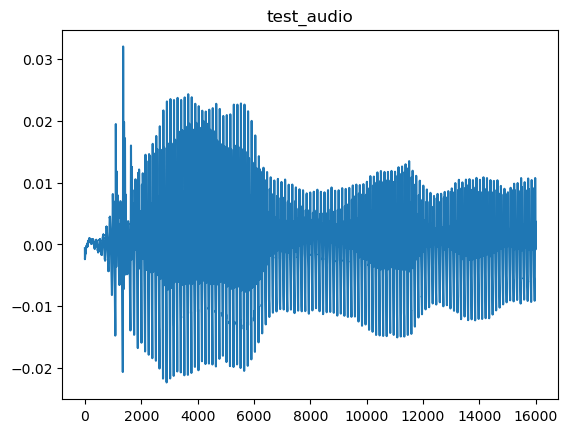

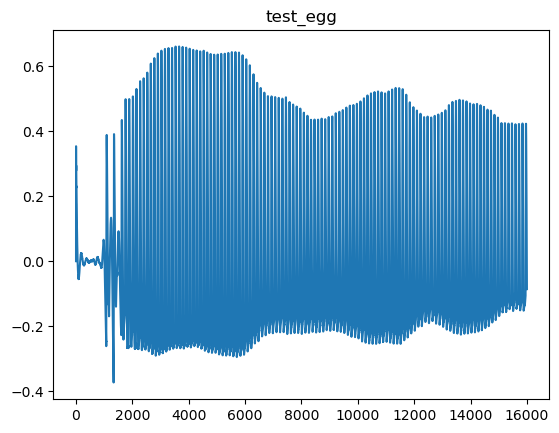

In [187]:
# plot test_audio and test_egg
plt.figure()
plt.plot(test_audio)
plt.title('test_audio')
plt.show()

plt.figure()
plt.plot(test_egg)
plt.title('test_egg')
plt.show()


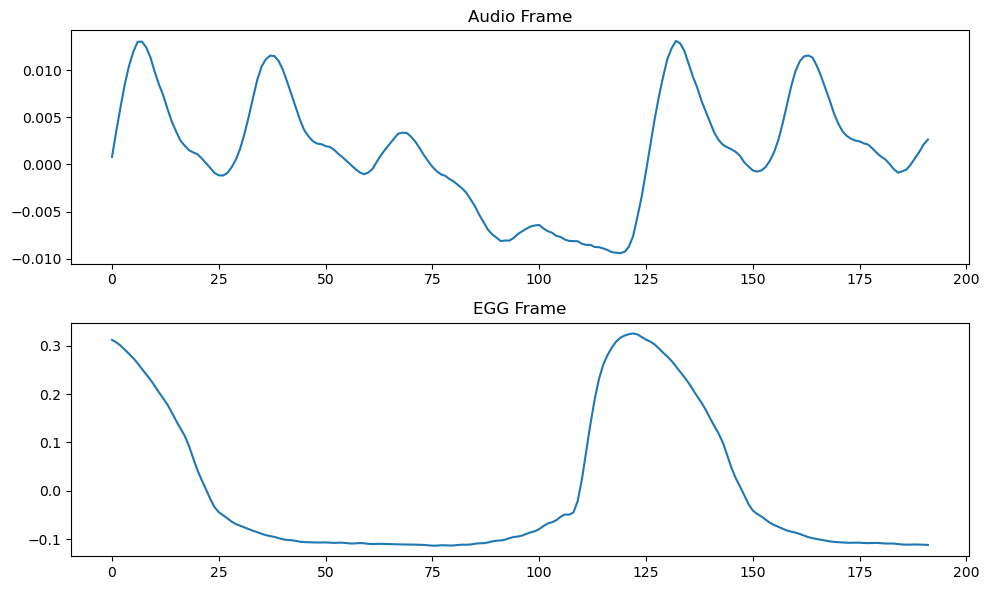

In [188]:
# plot a random audio and EGG frames
raw_index = np.random.randint(0, len(audio_frames))
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_frames[raw_index])
plt.title("Audio Frame")
plt.subplot(2, 1, 2)
plt.plot(egg_frames[raw_index])
plt.title("EGG Frame")
plt.tight_layout()
plt.show()


In [189]:
# Instantiate dataset
dataset = AudioEGGDataset(audio_frames, egg_frames)
# Create train and validation and test sets
batch_size = 512  # Adjust as necessary
train_size = int(0.85 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [194]:
# Training
experiment_name = input("Enter the experiment name or identifier: ")
base_dir = r'F:\A2E git\A2E'
chkpt_dir, models_dir, logs_dir = create_experiment_folders(base_dir, experiment_name)
# After training, load the best model for direct usage
best_model_path = os.path.join(models_dir, 'best_model.pt')

# Instantiate the model
channels = 32  # You may need to tune this based on your dataset
model = WaveNet(input_channels=1, dilation_channels=channels)

# Instantiate the TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Instantiate the Cosine Similarity Loss
# criterion = CosineSimilarityLoss()
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
best_val_loss = float('inf')
def train_model(model, dataloader, val_dataloader, best_val_loss,starting_epoch, device, criterion, optimizer, scheduler, writer, chkpt_dir, best_model_path, num_epochs=100):
    """
    Train a model with the given data, optimizer, loss function, and other parameters.

    Args:
    - model (torch.nn.Module): The model to train.
    - dataloader (DataLoader): The DataLoader for training data.
    - val_dataloader (DataLoader): The DataLoader for validation data.
    - device (torch.device): The device to run the training on (CPU or GPU).
    - criterion (function): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
    - scheduler (torch.optim.lr_scheduler): Scheduler for learning rate adjustment.
    - writer (SummaryWriter): TensorBoard writer for logging.
    - chkpt_dir (str): Directory to save checkpoints.
    - best_model_path (str): Path to save the best model.
    - num_epochs (int): Number of epochs to train the model.

    Returns:
    - None
    """
    for epoch in range(starting_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 1000 == 0:  # Log every 1000 batches
                writer.add_scalar('Training Loss', loss.item(), epoch * len(dataloader) + i)

        average_loss = running_loss / len(dataloader)
        writer.add_scalar('Average Training Loss', average_loss, epoch)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_dataloader)
        writer.add_scalar('Validation Loss', val_loss, epoch)
        print(f"Validation Loss: {val_loss}")

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning Rate', current_lr, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch}: New best model saved with loss {val_loss}")

        # Save checkpoint
        if epoch % 1 == 0:  # Save every 10 epochs in chkpt folder
            checkpoint_path = os.path.join(chkpt_dir, f'checkpoint_{epoch}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': running_loss / len(dataloader),
                'val_loss': val_loss,
                'lr': current_lr
            }, checkpoint_path)

        for name, param in model.named_parameters():
            writer.add_histogram(f'{name}', param, epoch)
            if param.grad is not None:
                writer.add_histogram(f'{name}.grad', param.grad, epoch)

def load_checkpoint(model, optimizer, scheduler, chkpt_dir, start_epoch=0):
    """
    Load a checkpoint if exists and return the epoch number to resume training from.

    Args:
    - model (torch.nn.Module): The model to load state dict into.
    - optimizer (torch.optim.Optimizer): The optimizer to load state dict into.
    - scheduler (torch.optim.lr_scheduler): Scheduler to load the state dict into.
    - chkpt_dir (str): Directory where checkpoints are saved.
    - start_epoch (int, optional): The starting epoch if no checkpoint is found.

    Returns:
    - model (torch.nn.Module): The model with loaded state dict.
    - optimizer (torch.optim.Optimizer): The optimizer with loaded state dict.
    - scheduler (torch.optim.lr_scheduler): The scheduler with loaded state dict.
    - start_epoch (int): The epoch training should resume from.
    """
    import os
    latest_chkpt_path = None
    highest_epoch = -1

    # Search for the latest checkpoint
    for filename in os.listdir(chkpt_dir):
        if filename.startswith('checkpoint_') and filename.endswith('.pt'):
            epoch_num = int(filename.split('_')[1].split('.')[0])
            if epoch_num > highest_epoch:
                highest_epoch = epoch_num
                latest_chkpt_path = os.path.join(chkpt_dir, filename)

    # Load the latest checkpoint if exists
    if latest_chkpt_path is not None:
        checkpoint = torch.load(latest_chkpt_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['val_loss']
        print(f"Loaded checkpoint '{latest_chkpt_path}' (epoch {checkpoint['epoch']}).")
    else:
        print("No checkpoint found. Starting a new model.")
        best_val_loss = float('inf')


    return model, optimizer, scheduler, start_epoch, best_val_loss

model, optimizer, scheduler, starting_epoch, best_val_loss = load_checkpoint(model, optimizer, scheduler, chkpt_dir)
train_model(model, dataloader, val_dataloader,best_val_loss, starting_epoch, device, criterion, optimizer, scheduler, writer, chkpt_dir, best_model_path, num_epochs=500)


No checkpoint found. Starting a new model.
Validation Loss: 0.11112184822559357
Epoch 0: New best model saved with loss 0.11112184822559357
Validation Loss: 0.06811145444711049
Epoch 1: New best model saved with loss 0.06811145444711049
Validation Loss: 0.0364061693350474
Epoch 2: New best model saved with loss 0.0364061693350474
Validation Loss: 0.03214732992152373
Epoch 3: New best model saved with loss 0.03214732992152373
Validation Loss: 0.02744382433593273
Epoch 4: New best model saved with loss 0.02744382433593273
Validation Loss: 0.02374974824488163
Epoch 5: New best model saved with loss 0.02374974824488163
Validation Loss: 0.02077769177655379
Epoch 6: New best model saved with loss 0.02077769177655379
Validation Loss: 0.018797156090537708
Epoch 7: New best model saved with loss 0.018797156090537708
Validation Loss: 0.017409118513266247
Epoch 8: New best model saved with loss 0.017409118513266247
Validation Loss: 0.01595652662217617
Epoch 9: New best model saved with loss 0.015

KeyboardInterrupt: 

In [195]:
# prediction
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        a, e = data
        a = a.to(device)
        e = e.to(device)
        output = model(a)

In [ ]:
# save the model
torch.save(model.state_dict(), 'WaveNet.pth')


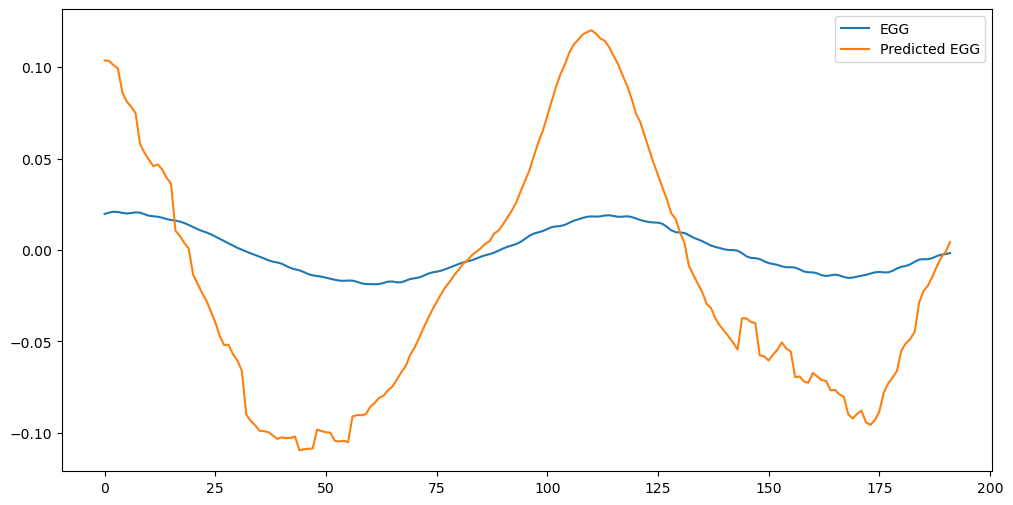

In [207]:
# plot prediction
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
e = e.cpu()
output = output.cpu()

# pick a random sample
sample = np.random.randint(0, len(e))
egg_sample = e[sample].squeeze()
output_sample = output[sample].squeeze()

# Plot the first sample
plt.figure(figsize=(12, 6))
plt.plot(egg_sample, label='EGG')
plt.plot(output_sample, label='Predicted EGG')
plt.legend()

plt.show()

In [ ]:
# save wav
import soundfile as sf
# save the first predicted EGG as wav
output_wav = output[0]
# save wav in the current folder using soundfile

sf.write('output.wav', output_wav.squeeze().numpy(), samplerate)

# save the first ground truth EGG as wav
egg_wav = egg[0]
sf.write('egg.wav', egg_wav.squeeze().numpy(), samplerate)


In [ ]:
def predict_frames(frames, model, device):
    predicted_frames = np.zeros_like(frames)
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No gradients needed
        for i in range(frames.shape[0]):
            frame = torch.from_numpy(frames[i, :]).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            frame = frame.to(device)  # Move to device
            output = model(frame)
            predicted_frames[i, :] = output.squeeze().cpu().numpy()  # Remove batch dimension and move to cpu
    return predicted_frames

def overlap_and_add(frames, hop_length):
    output_length = hop_length * (frames.shape[0] - 1) + frames.shape[1]
    output = np.zeros(output_length)
    count = np.zeros(output_length)  # To keep track of additions made to each position
    
    for i in range(frames.shape[0]):
        start = i * hop_length
        end = start + frames.shape[1]
        output[start:end] += frames[i, :]
        count[start:end] += 1  # Increment count for each addition
    
    # Avoid division by zero
    count[count == 0] = 1
    output /= count  # Average the output
    return output


frame_length = 120
hop_length = 60

# var repeatition
predict_audio_frames = segment_audio(audio[176000:184000], samplerate, frame_length_ms= frame_length, hop_length_samples = hop_length)
predicted_egg_frames = predict_frames(predict_audio_frames, model, device)
predicted_egg = overlap_and_add(predicted_egg_frames, hop_length)



In [ ]:
import soundfile as sf
# save wave
sf.write('predicted_egg.wav', predicted_egg, samplerate)
sf.write('test_egg.wav', egg, samplerate)